In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.waveform import GenerateEMRIWaveform
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
from few.utils.utility import *

import GWGen
from GWGen.WFGenerator import *

# set initial parameters
M = 1e5
mu = 1e1
a = .6
p0 = 14.0
e0 = 0.9
iota0 = 0.
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 = 0.
Phi_r0 = 0.


qS = 0.2
phiS = 0.
qK = 0.
phiK = 0.
dist = 1.0
mich = False
dt = 15
T = 2

use_gpu = True

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiralkwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "npoints":100
}

# keyword arguments for summation generator (AAKSummation)
sumkwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

FEWwfgen = Pn5AAKWaveform(inspiral_kwargs=inspiralkwargs.copy(), sum_kwargs=sumkwargs.copy(), use_gpu=use_gpu)
MYwfgen = EMRIWaveform(inspiral_kwargs=inspiralkwargs.copy(), sum_kwargs=sumkwargs.copy(), use_gpu=use_gpu)

# Trajectory Modules

In [3]:
len(FEWtraj[0])

225

Integration halted before ending time. Reasons: Separatrix reached!
Time to generate FEW traj: 0.04164433479309082
Time to generatoe My traj: 0.3030238151550293


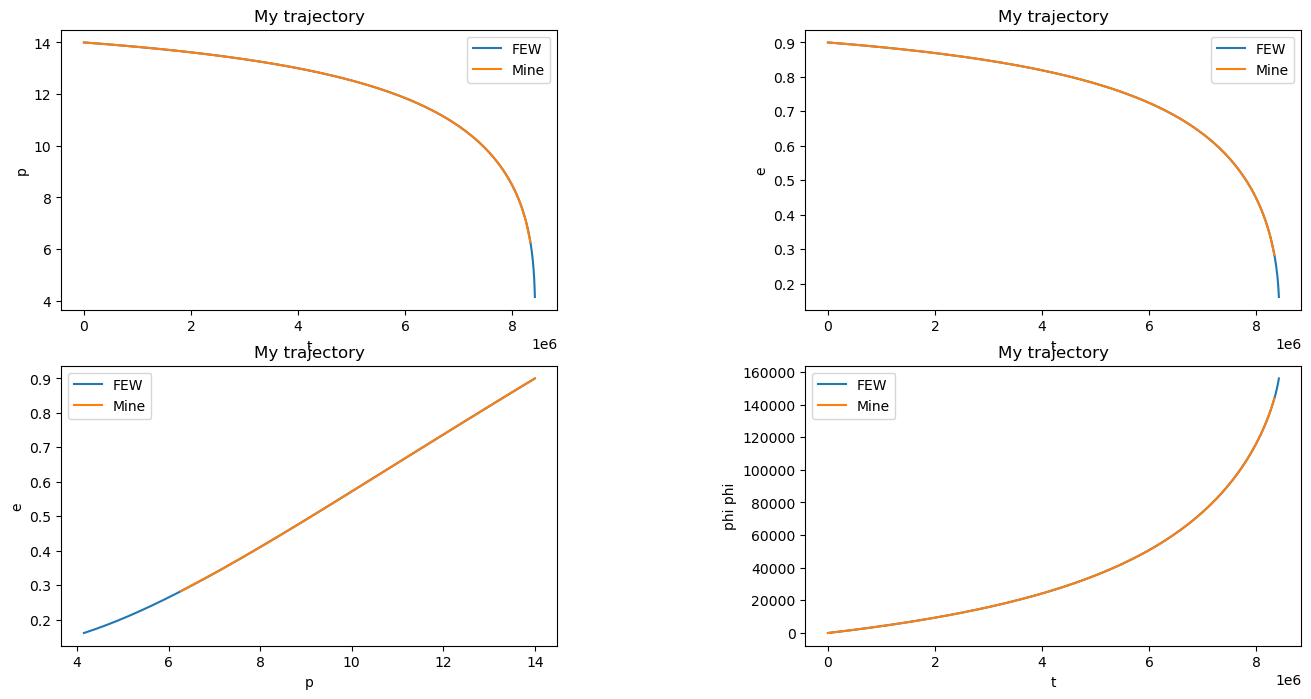

In [2]:
aa = time.time()
FEWtraj = FEWwfgen.inspiral_generator(M, mu, a, p0, e0, Y0, T=T)
bb = time.time()
MYtraj = MYwfgen.inspiral_generator(M, mu, a, p0, e0, Y0, T=T, **inspiralkwargs.copy())
print("Time to generate FEW traj: {0}\nTime to generatoe My traj: {1}".format(bb-aa,time.time()-bb))
tf,pf, ef, xf,phiphif = FEWtraj[:5]
t,p,e,x,phiphi = MYtraj[:5]
fig,axes=plt.subplots(2,2)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(16,8)
axes[0,0].set_title("My trajectory")
axes[0,0].set_ylabel("p")
axes[0,0].set_xlabel("t")
axes[0,0].plot(tf,pf, label="FEW")
axes[0,0].plot(t,p, label="Mine")
axes[0,0].legend()

axes[0,1].set_title("My trajectory")
axes[0,1].set_ylabel("e")
axes[0,1].set_xlabel("t")
axes[0,1].plot(tf,ef, label="FEW")
axes[0,1].plot(t,e, label="Mine")
axes[0,1].legend()

axes[1,0].set_title("My trajectory")
axes[1,0].set_ylabel("e")
axes[1,0].set_xlabel("p")
axes[1,0].plot(pf,ef, label="FEW")
axes[1,0].plot(p,e, label="Mine")
axes[1,0].legend()

axes[1,1].set_title("My trajectory")
axes[1,1].set_ylabel("phi phi")
axes[1,1].set_xlabel("t")
axes[1,1].plot(tf,phiphif, label="FEW")
axes[1,1].plot(t,phiphi, label="Mine")
axes[1,1].legend()

# Waveform Modules

In [ ]:
nmodes = int(30*e0)
aa=time.time()
print("Generating FEW Waveform")
FEWwf = FEWwfgen.create_waveform(FEWtraj[0], M,a,*FEWtraj[1:], mu, qS, phiS, qK, phiK, dist, nmodes,mich=mich,dt=dt,T=T)
bb=time.time()
print("Generating MY Waveform")
MYwf = MYwfgen.create_waveform(MYtraj[0], M,a,*MYtraj[1:], mu, qS, phiS, qK, phiK, dist, nmodes,mich=mich,dt=dt,T=T)
print("Time to generate FEW wf: {0}\nTime to generatoe My wf: {1}".format(bb-aa,time.time()-bb))

if use_gpu:
    FEWwaveform = FEWwf.get()
    mywf = MYwf.get()
else:
    FEWwaveform=FEWwf
    mywf=MYwf
fig,axes = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
fig.set_size_inches(16,8)


t = np.arange(len(mywf)) * dt
axes[0,0].set_title("My Model")
axes[0,0].plot(t, mywf.real);
xticks = axes[0,0].get_xticks()[1:-1]
axes[0,0].set_xticks(xticks, [int(i)/100 for i in (xticks*100/(60*60*24*365))]);
axes[0,0].set_xlabel("years");
axes[0,0].set_ylabel("strain");


tf =np.arange(len(FEWwaveform)) * dt;
axes[0,1].set_title("FEW Model")
axes[0,1].plot(tf, FEWwaveform.real);
xticks = axes[0,1].get_xticks()[1:-1]
axes[0,1].set_xticks(xticks, [int(i)/100 for i in (xticks*100/(60*60*24*365))]);
axes[0,1].set_xlabel("years");
axes[0,1].set_ylabel("strain");

axes[1,0].set_title("Overlap")
startinginx = 0
cutoffinx = 2000;
axes[1,0].plot(t[startinginx:cutoffinx], mywf.real[startinginx:cutoffinx]);
axes[1,0].plot(tf[startinginx:cutoffinx], FEWwaveform.real[startinginx:cutoffinx]);
xticks = axes[1,0].get_xticks()[1:-1]
axes[1,0].set_xticks(xticks, [int(i)/100 for i in (xticks*100/(60*60*24*31))]);
axes[1,0].set_xlabel("months");
axes[1,0].set_ylabel("strain");

axes[1,1].text(0.5,0.5, "Mismatch = {0}".format(get_mismatch(FEWwaveform, mywf)))
axes[1,1].axis("off");

Generating FEW Waveform


/mnt/Data_Volume/Computer_Programs/Anaconda/envs/few_env/lib/python3.7/site-packages/few/summation/aakwave.py:228: UserWarning: Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6.
  "Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6."
/mnt/Data_Volume/Computer_Programs/Anaconda/envs/few_env/lib/python3.7/site-packages/few/summation/aakwave.py:244: UserWarning: qK is within 1e-6 of the poles. We shift this value automatically away from poles by 1e-6.
  "qK is within 1e-6 of the poles. We shift this value automatically away from poles by 1e-6."
